### Import Libraries

In [37]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

### Loading and Preprocessing data

In [3]:
# Define the paths to the dataset folders
data_path ='data'
non_vehicle_folder = os.path.join(data_path, 'non-vehicles')
vehicle_folder = os.path.join(data_path, 'vehicles')

# Initialize lists to hold image data and labels
images = []
labels = []

# Counters for labeling
car_count = 0
non_car_count = 0

# Helper function to process images from a given folder
def process_images_from_folder(folder_path, is_vehicle):
    global car_count, non_car_count
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if the image couldn't be read
        
        # Resize image to 224x224 pixels
        img = cv2.resize(img, (224, 224))
        images.append(img)
        
        # Assign labels based on whether it's a vehicle or non-vehicle
        if is_vehicle:
            label = 1  # Label for car
            car_count += 1
        else:
            label = 0  # Label for non-car
            non_car_count += 1
        
        labels.append(label)

# Process images from both folders
process_images_from_folder(vehicle_folder, is_vehicle=True)
process_images_from_folder(non_vehicle_folder, is_vehicle=False)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels:", labels)


Images shape: (17760, 224, 224, 3)
Labels: [1 1 1 ... 0 0 0]


### Normalizing and Splitting data

In [4]:
# Normalize the images
images = images / 255.0

# Convert labels to categorical
labels = to_categorical(labels, num_classes=2)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### Building the Model

CNN Model experimenting with the potential benefits by simply adding layers

In [5]:
# Initialize the model
model = Sequential()

# Add an Input layer as the first layer in the model
model.add(Input(shape=(224, 224, 3)))

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


2024-08-03 19:45:44.769539: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [6]:
# Initialize the image data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit the data generator on the training data
datagen.fit(X_train)

### Training the Model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the data generator
history = model.fit(datagen.flow(X_train, y_train, batch_size=128), 
                    epochs=50, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
111/111 [==============================] - 103s 822ms/step - loss: 0.7804 - accuracy: 0.6975 - val_loss: 0.2621 - val_accuracy: 0.9184
Epoch 2/50
111/111 [==============================] - 90s 808ms/step - loss: 0.2262 - accuracy: 0.9161 - val_loss: 0.1877 - val_accuracy: 0.9271
Epoch 3/50
111/111 [==============================] - 90s 808ms/step - loss: 0.1580 - accuracy: 0.9409 - val_loss: 0.1109 - val_accuracy: 0.9671
Epoch 4/50
111/111 [==============================] - 90s 807ms/step - loss: 0.0991 - accuracy: 0.9644 - val_loss: 0.0781 - val_accuracy: 0.9772
Epoch 5/50
111/111 [==============================] - 89s 805ms/step - loss: 0.0862 - accuracy: 0.9704 - val_loss: 0.0780 - val_accuracy: 0.9733
Epoch 6/50
111/111 [==============================] - 90s 807ms/step - loss: 0.0820 - accuracy: 0.9710 - val_loss: 0.0946 - val_accuracy: 0.9648
Epoch 7/50
111/111 [==============================] - 90s 808ms/step - loss: 0.0765 - accuracy: 0.9718 - val_loss: 0.0469 - val_a

### Evaluating the Model

In [21]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

111/111 [==============================] - 2s 16ms/step - loss: 0.0132 - accuracy: 0.9963
Test Accuracy: 99.63%


### Making Predictions

In [19]:
# Print current working directory
print("Current working directory:", os.getcwd())

# List directory contents
print("Contents of vehicle_folder:", os.listdir(vehicle_folder))

# Test on a new image
test_img_path = 'vehicle_folder/10.jpg'
try:
    result = predict_vehicle(model, test_img_path)
    print(f'The image is predicted as: {result}')
except FileNotFoundError as e:
    print(e)

# Display the test image with prediction
img = cv2.imread(test_img_path)
if img is not None:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(result)
    plt.show()
else:
    print(f"Image at path '{test_img_path}' not found, so it cannot be displayed.")


Current working directory: /home/ec2-user/SageMaker/Image-Detection
Contents of vehicle_folder: ['488.png', 'middle (325).png', '459.png', '1491.png', 'right (81).png', 'far (338).png', 'far (635).png', '636.png', '4142.png', '4250.png', 'right (193).png', '4689.png', '4201.png', 'right (637).png', '102.png', 'middle (148).png', '2322.png', '1213.png', '3965.png', '3810.png', '1233.png', '3039.png', '4138.png', '263.png', '476.png', '4058.png', '2413.png', 'right (574).png', 'middle (55).png', '2326.png', 'left (447).png', '354.png', 'left (195).png', '2152.png', '3938.png', 'right (420).png', 'left (113).png', 'left (269).png', '3331.png', '4218.png', '1.png', 'left (257).png', '1099.png', '2465.png', 'far (152).png', '880.png', '5490.png', 'right (186).png', '3510.png', '5622.png', '3270.png', '1033.png', '5761.png', '1841.png', '4523.png', '4438.png', '5014.png', 'middle (338).png', '2989.png', 'far (550).png', 'far (823).png', '1069.png', '5629.png', '1214.png', 'left (676).png', '

[ WARN:0@5501.858] global loadsave.cpp:241 findDecoder imread_('vehicle_folder/10.jpg'): can't open/read file: check file path/integrity
[ WARN:0@5501.858] global loadsave.cpp:241 findDecoder imread_('vehicle_folder/10.jpg'): can't open/read file: check file path/integrity


In [26]:
# Function to preprocess and predict on a new image
def predict_vehicle(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    return 'Car' if np.argmax(prediction) == 1 else 'Non-car'

# Test on a new image
test_img_path = os.path.join(vehicle_folder, '10.png')  # Corrected test image path
try:
    result = predict_vehicle(model, test_img_path)
    print(f'The image is predicted as: {result}')
except FileNotFoundError as e:
    print(e)

1/1 [==============================] - 0s 17ms/step
The image is predicted as: Car


### Visualization

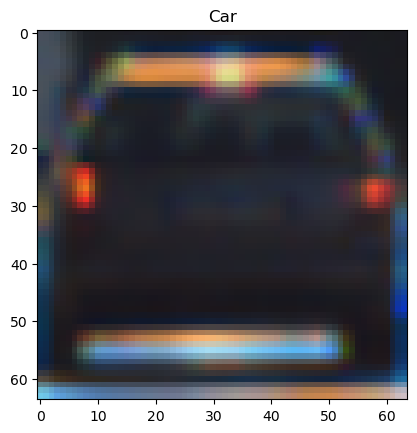

In [27]:
# Display the test image with prediction
img = cv2.imread(test_img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(result)
plt.show()

### Model Performance Report

111/111 [==============================] - 2s 16ms/step
Model Evaluation Report

1. Overall Accuracy: 99.63%
   Test Loss: 0.0132

2. Confusion Matrix:
[[1795    6]
 [   7 1744]]

3. Classification Report:
              precision    recall  f1-score   support

 Non-vehicle       1.00      1.00      1.00      1801
     Vehicle       1.00      1.00      1.00      1751

    accuracy                           1.00      3552
   macro avg       1.00      1.00      1.00      3552
weighted avg       1.00      1.00      1.00      3552




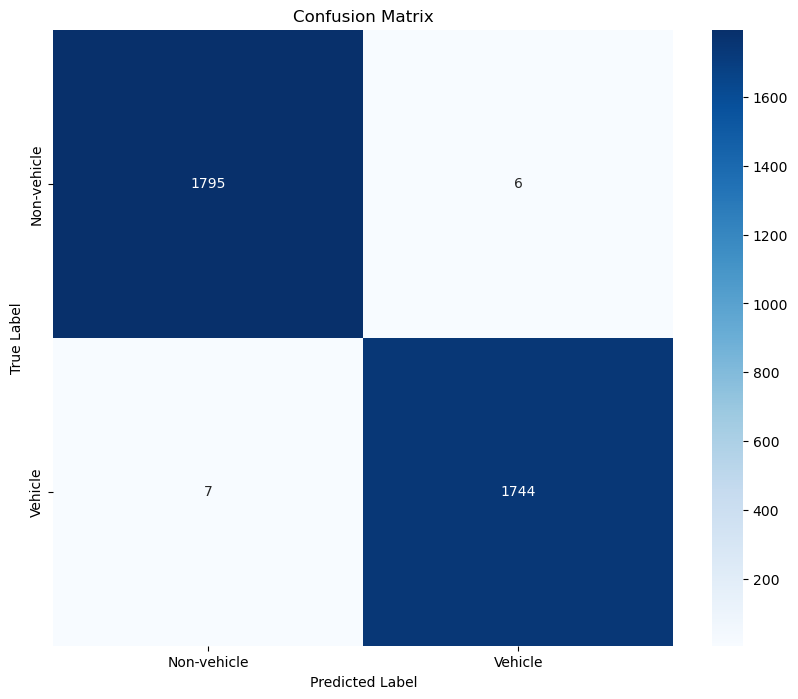

In [42]:
from IPython.display import display

def generate_model_report(model, X_test, y_test, class_names):
    report = "Model Evaluation Report\n========================\n\n"
    
    # 1. Predict on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # 2. Overall Accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    report += f"1. Overall Accuracy: {test_accuracy*100:.2f}%\n"
    report += f"   Test Loss: {test_loss:.4f}\n\n"
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    report += "2. Confusion Matrix:\n"
    report += str(cm) + "\n\n"
    
    # 4. Classification Report
    class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
    report += "3. Classification Report:\n"
    report += class_report + "\n"
    
    # 5. Visualizations
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    return report, plt

# Example usage (you would run this after training your model)
class_names = ['Non-vehicle', 'Vehicle']
report, confusion_matrix_plot = generate_model_report(model, X_test, y_test, class_names)

# Print the report
print(report)

# Display the confusion matrix
display(confusion_matrix_plot.gcf())
plt.close()